In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm


from dataset import patch_dataset
from dataset import patch_dataset_test
from trainer import train
from models import basic_FCN, UNet

In [2]:
file_path_X = 'X_train'
file_path_Y = 'Y_train'
index = np.load('X_train/_index_good.npy')

dataset = patch_dataset(file_path_X, file_path_Y,index,load_in_ram=True, numtype=torch.float32)

In [3]:
batch_size = 64

dataloader = DataLoader(dataset, batch_size, shuffle=True)

for x,y in tqdm(dataloader):
    print(x.shape)
    print(y.shape)
    break

  0%|                                                    | 0/64 [00:00<?, ?it/s]

torch.Size([64, 1, 160, 272])
torch.Size([64, 3, 160, 272])


In [4]:
model = UNet(in_channels=1, out_channels=3, features=[32, 64, 128, 256])
#model.to('mps')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = criterion = torch.nn.CrossEntropyLoss()

In [5]:
x, y = next(iter(dataloader))
#x = x.to('mps')
#y = y.to('mps')
model(x).shape

torch.Size([64, 3, 160, 272])

In [6]:
train(model, optimizer, loss_fn, dataloader, device='cpu', epochs=5)

100%|███████████████████████████████████████████| 64/64 [52:40<00:00, 49.38s/it]


Epoch 1/5, Train Loss: 0.6624


100%|███████████████████████████████████████████| 64/64 [58:08<00:00, 54.50s/it]


Epoch 2/5, Train Loss: 0.1972


100%|█████████████████████████████████████████| 64/64 [1:01:52<00:00, 58.00s/it]


Epoch 3/5, Train Loss: 0.1113


100%|█████████████████████████████████████████| 64/64 [1:05:51<00:00, 61.75s/it]


Epoch 4/5, Train Loss: 0.0802


100%|█████████████████████████████████████████| 64/64 [1:07:38<00:00, 63.41s/it]

Epoch 5/5, Train Loss: 0.0719


  0%|                                                    | 0/64 [00:00<?, ?it/s]

torch.Size([160, 272])
torch.Size([64, 3, 160, 272])


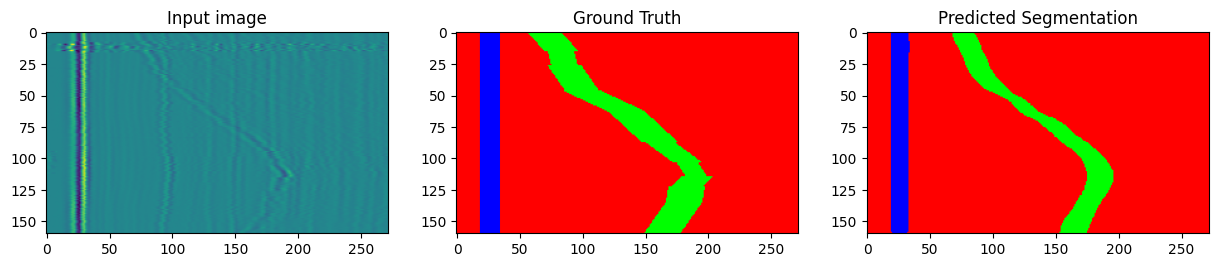

  0%|                                                    | 0/64 [00:19<?, ?it/s]


In [9]:
for x,y in tqdm(dataloader):
    #x = x.to('mps')
    #y = y.to('mps')
    logits = model(x)[0]
    pred = torch.argmax(logits, dim=0)
    print(pred.shape)
    print(y.shape)
    #print(y[0, 20, 25, :])

    pred = pred.cpu().detach().numpy()
    # Define RGB colors for each class
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue

    # Convert class indices to RGB colors
    segmentation_mask = colors[pred]  # Shape: (H, W, 3)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(x[0].permute(1, 2, 0).cpu().detach().numpy())
    
    axs[0].set_title('Input image')

    axs[1].imshow(y[0].permute(1, 2, 0).cpu().detach().numpy())
    axs[1].set_title('Ground Truth')

    axs[2].imshow(segmentation_mask)
    axs[2].set_title('Predicted Segmentation')

    plt.show()

    

    break

In [2]:
file_path_X = 'X_test'
index = np.load('X_test/_index.npy')

dataset_test = patch_dataset_test(file_path_X,index,load_in_ram=True, numtype=torch.float32)

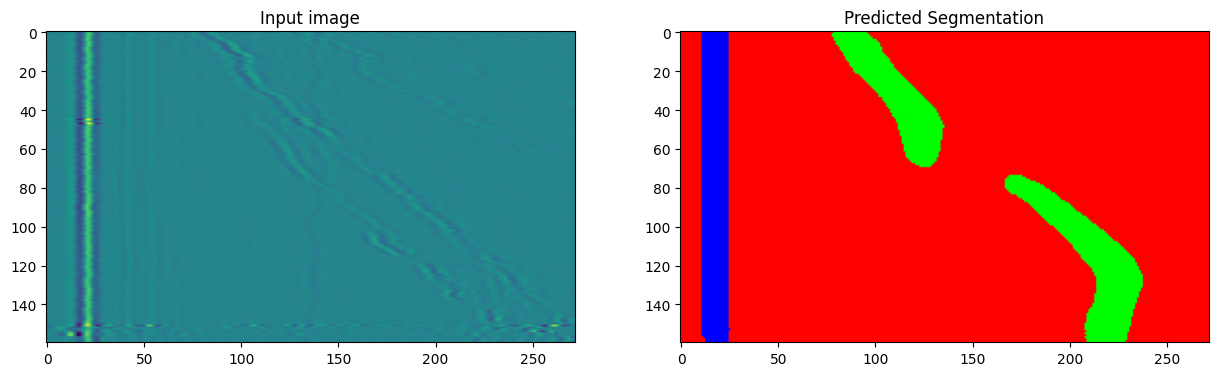

In [10]:
model = UNet(in_channels=1, out_channels=3, features=[32, 64, 128, 256])
model.load_state_dict(torch.load('models/custom_loss_Unet.pth', weights_only=True))

model.eval()

for x in dataset_test:
    x = torch.unsqueeze(x,0)
    logits = model(x)[0]
    pred = torch.argmax(logits, dim=0)
    
    pred = pred.cpu().detach().numpy()
    # Define RGB colors for each class
    colors = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255]])  # Red, Green, Blue

    # Convert class indices to RGB colors
    segmentation_mask = colors[pred]  # Shape: (H, W, 3)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(x[0].permute(1, 2, 0).cpu().detach().numpy())
    
    axs[0].set_title('Input image')


    axs[1].imshow(segmentation_mask)
    axs[1].set_title('Predicted Segmentation')

    plt.show()

    break

In [11]:
import os
from loss import custom_loss, custom_output

model.eval()
predictions = []

os.makedirs('predictions', exist_ok=True)

with torch.no_grad():
    for i in range(len(dataset_test)):
        x = torch.from_numpy(np.load(file_path_X+'/'+index[i])).unsqueeze(0).unsqueeze(0).to(torch.float32)
        logits = model(x)[0]
        pred_custom = custom_output(logits,10)
        pred_custom = pred_custom.cpu().detach()
        pred_custom = pred_custom.numpy()
        predictions.append(pred_custom)
        
        # Save the prediction
        filename = os.path.basename(index[i])
        np.save(f'predictions/{filename}', pred)

predictions = np.array(predictions)
print(predictions.shape)  # Should print (num_images, 160, 272)













































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































(972, 160, 272)


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

size_labels = 272
predictions = {'test':{}}
for phase in predictions.keys():
    img_save_dir = Path('predictions')
    for img_path in img_save_dir.glob('*.npy'):
        name = img_path.stem
        if name in predictions[phase]:
            continue
        prediction = np.load(img_path)
        if prediction.shape[1]!=size_labels:
            prediction_aux = -1+np.zeros(160*size_labels) # Adding padding to ensure all masks have the same size
            prediction_aux[0:160*160] = prediction.flatten()
        else:
            prediction_aux = prediction.flatten()
        predictions[phase].update({name:prediction_aux})
pd.DataFrame(predictions['test'], dtype='int').T.to_csv(Path(f'submits/y_test_csv_file.csv'))